# Introduction to Compartmental Models

Compartmental models in epidemiology are used to model the spread of infectious diseases by dividing the population into compartments based on disease status. These models help in understanding how diseases spread and assessing the impact of interventions.

## The SIR Model

The SIR model can be described by the following set of differential equations:

- $\frac{dS}{dt} = -\frac{\beta I S}{N}$
- $\frac{dI}{dt} = \frac{\beta I S}{N} - \gamma I$
- $\frac{dR}{dt} = \gamma I$

where \(N\) is the total population.

These equations represent the rate of change over time for each compartment in the model:

- $S$ represents the number of susceptible individuals,
- $I$ represents the number of infected individuals,
- $R$ represents the number of recovered individuals.

The parameter $\beta$ represents the transmission rate, which affects how quickly the disease spreads from infected to susceptible individuals, while $\gamma$ represents the recovery rate, indicating the fraction of infected individuals who recover from the disease each day.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint


In [2]:
# SIR model differential equations.
def sir_model(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt


In [3]:
# Total population, N.
N = 1000
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 0.3, 0.1
# A grid of time points (in days)
t = np.linspace(0, 160, 160)

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(sir_model, y0, t, args=(N, beta, gamma))
S, I, R = ret.T


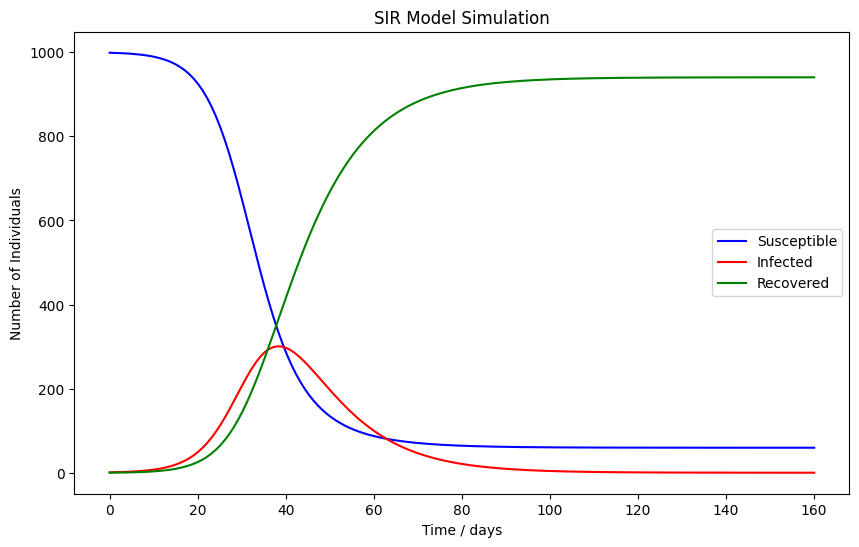

In [4]:
# Plotting
plt.figure(figsize=(10,6))
plt.plot(t, S, 'b', label='Susceptible')
plt.plot(t, I, 'r', label='Infected')
plt.plot(t, R, 'g', label='Recovered')
plt.title('SIR Model Simulation')
plt.xlabel('Time / days')
plt.ylabel('Number of Individuals')
plt.legend()
plt.show()

## Extending the SIR Model to Include Spatial Dynamics

After understanding the basic dynamics of the SIR model, we can extend it to incorporate spatial aspects. This involves considering multiple regions or compartments, each with its own SIR dynamics, and allowing for interaction between these regions to model the spread of an infectious disease across space.

### Spatial Model Concept

In the spatial SIR model, we divide the total population into several regions or compartments. Each compartment has its own susceptible ($S$), infected ($I$), and recovered ($R$) populations, and the disease can spread within and between these compartments. This approach allows us to model not just the spread of disease over time but also its spread across different geographical areas or populations.

### Incorporating Spatial Dynamics into the SIR Model

To incorporate spatial dynamics, we use the same basic differential equations from the SIR model for each region but add terms to represent the movement or interaction between regions.

## generic SIR model for any number of regions

In [5]:
def generic_spatial_sir(y, t, N, beta, gamma, M):
    """
    A generic spatial SIR model for any number of regions.
    
    Parameters:
    - y: Initial state vector for all regions [S1, I1, R1, S2, I2, R2, ..., SN, IN, RN].
    - t: Time array for the simulation.
    - N: Array of population sizes for each region.
    - beta: Transmission rate for each region.
    - gamma: Recovery rate for each region.
    - M: Mobility matrix representing movement between regions (NxN matrix).
    
    Returns:
    - The derivatives (dSdt, dIdt, dRdt) for all regions.
    """
    
    num_regions = len(N)
    derivatives = np.zeros(num_regions * 3) # Initialize derivatives vector
    
    for i in range(num_regions):
        S, I, R = y[i*3:(i+1)*3] # Extract S, I, R for region i
        
        # Calculate net movement for susceptible and infected individuals
        net_S_movement = sum(M[j][i] * y[j*3] - M[i][j] * S for j in range(num_regions))
        net_I_movement = sum(M[j][i] * y[j*3+1] - M[i][j] * I for j in range(num_regions))
        net_R_movement = sum(M[j][i] * y[j*3+2] - M[i][j] * R for j in range(num_regions))

        # SIR model equations with mobility
        dSdt = -beta[i] * S * I / N[i] + net_S_movement
        dIdt = beta[i] * S * I / N[i] - gamma[i] * I + net_I_movement
        dRdt = gamma[i] * I + net_R_movement
        
        # Update derivatives
        derivatives[i*3:(i+1)*3] = [dSdt, dIdt, dRdt]
    
    return derivatives

In [6]:
# Example usage for 3 regions
N = [1000, 800, 1200]  # Population sizes
beta = [0.2, 0.1, 0.3]  # Transmission rates
gamma = [0.1, 0.05, 0.15]  # Recovery rates
M = np.array([[0, 0.01, 0.02],  # Mobility matrix
              [0.01, 0, 0.01],
              [0.02, 0.01, 0]])

# Initial conditions [S1, I1, R1, S2, I2, R2, S3, I3, R3]
y0 = [999, 1, 0, 800, 0, 0, 1200, 0, 0]

t = np.linspace(0, 200, 1000)  # Time grid

# Solve the differential equations
sol = odeint(generic_spatial_sir, y0, t, args=(N, beta, gamma, M))

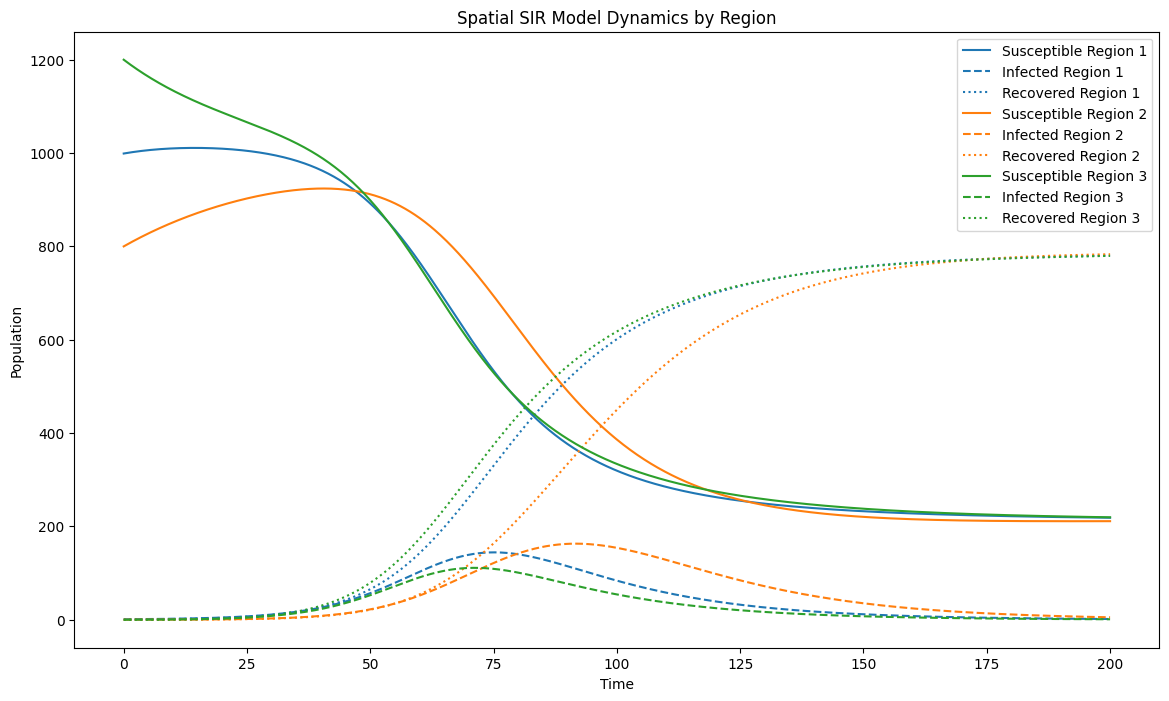

In [7]:
# Define colors for each region
colors = plt.cm.tab10.colors

# Define line styles for S, I, R populations
line_styles = ['-', '--', ':']  # solid, dashed, dotted

plt.figure(figsize=(14, 8))

for i in range(len(N)):
    # Plot susceptible population for region i
    plt.plot(t, sol[:, i*3], label=f'Susceptible Region {i+1}', color=colors[i], linestyle=line_styles[0])
    # Plot infected population for region i
    plt.plot(t, sol[:, i*3+1], label=f'Infected Region {i+1}', color=colors[i], linestyle=line_styles[1])
    # Plot recovered population for region i
    plt.plot(t, sol[:, i*3+2], label=f'Recovered Region {i+1}', color=colors[i], linestyle=line_styles[2])

plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Spatial SIR Model Dynamics by Region')
plt.legend()
plt.show()


In [8]:
colors = plt.cm.tab10.colors 

def plot_sir_2_locations(N1=1000, N2=1000, transmission1=0.2, transmission2=0.2, recovery1=0.1, recovery2=0.1, m12=0.01, m21=0.01, time=100):
    N = [N1, N2]  # Population sizes
    beta = [transmission1, transmission2]  # Transmission rates
    gamma = [recovery1, recovery2]  # Recovery rates
    M = np.array([[0, m12], [m21, 0]])  # Mobility matrix
    
    # Initial conditions [S1, I1, R1, S2, I2, R2]
    y0 = [N1 - 1, 1, 0, N2, 0, 0]  # One infected in region 1
    
    t = np.linspace(0, time, 1000)  # Time grid
    
    # Solve the differential equations
    sol = odeint(generic_spatial_sir, y0, t, args=(N, beta, gamma, M))
    
    # Plotting
    plt.figure(figsize=(14, 6))
    for i in range(len(N)):
        plt.plot(t, sol[:, i*3], label=f'Susceptible Region {i+1}', color=colors[i], linestyle='-')
        plt.plot(t, sol[:, i*3+1], label=f'Infected Region {i+1}', color=colors[i], linestyle='--')
        plt.plot(t, sol[:, i*3+2], label=f'Recovered Region {i+1}', color=colors[i], linestyle=':')
    
    plt.xlabel('Time')
    plt.ylabel('Population')
    plt.legend()
    plt.show()

In [9]:
from ipywidgets import interact, FloatSlider, IntSlider

# Create interactive widgets for the model parameters
interact(plot_sir_2_locations,
         N1=IntSlider(min=500, max=2000, step=100, value=1000, description='N1 Population Size'),
         N2=IntSlider(min=500, max=2000, step=100, value=1000, description='N2 Population Size'),
         transmission1=FloatSlider(min=0.01, max=1.0, step=0.01, value=0.2, description='Transmission1'),
         transmission2=FloatSlider(min=0.01, max=1.0, step=0.01, value=0.2, description='Transmission2'),
         recovery1=FloatSlider(min=0.01, max=1.0, step=0.01, value=0.1, description='Recovery1'),
         recovery2=FloatSlider(min=0.01, max=1.0, step=0.01, value=0.1, description='Recovery2'),
         m12=FloatSlider(min=0.0, max=0.1, step=0.01, value=0.01, description='Mobility 1->2'),
         m21=FloatSlider(min=0.0, max=0.1, step=0.01, value=0.01, description='Mobility 2->1'),
         time=FloatSlider(min=0.0, max=1000, step=1.0, value=100.0, description='Time')
        )


interactive(children=(IntSlider(value=1000, description='N1 Population Size', max=2000, min=500, step=100), In…

<function __main__.plot_sir_2_locations(N1=1000, N2=1000, transmission1=0.2, transmission2=0.2, recovery1=0.1, recovery2=0.1, m12=0.01, m21=0.01, time=100)>

# Stochastic SIR model

## Start with a non-spatial SIR

In [10]:
import numpy as np

def stochastic_sir(S0, I0, R0, beta, gamma, t_max):
    """
    Simple stochastic SIR model.
    
    Parameters:
    S0, I0, R0: Initial numbers of susceptible, infected, and recovered individuals.
    beta: Transmission rate.
    gamma: Recovery rate.
    t_max: Maximum time to simulate.
    
    Returns:
    A list of tuples (t, S, I, R) representing the state over time.
    """
    t = 0
    S, I, R = S0, I0, R0
    output = [(t, S, I, R)]
    
    while t < t_max and I > 0:
        # Rates of infection and recovery events
        rate_infection = beta * S * I / (S + I + R)
        rate_recovery = gamma * I
        rate_total = rate_infection + rate_recovery
        
        # Time until next event
        t_next = t + np.random.exponential(1 / rate_total)
        
        # Determine the type of event (infection or recovery)
        if np.random.rand() < rate_infection / rate_total:
            S -= 1
            I += 1
        else:
            I -= 1
            R += 1
            
        t = t_next
        output.append((t, S, I, R))
    
    return output


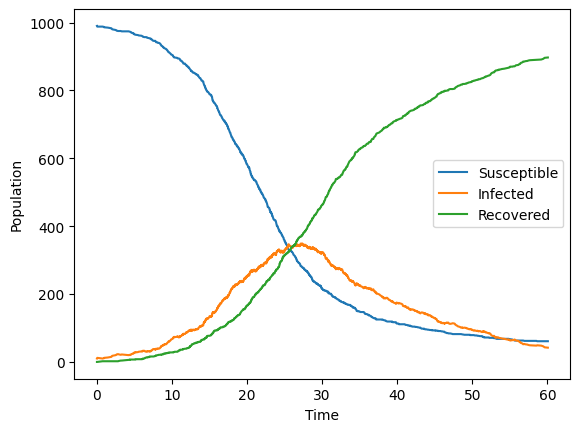

In [11]:
# Parameters for the simulation
S0 = 990
I0 = 10
R0 = 0
beta = 0.3
gamma = 0.1
t_max = 60

# Run the stochastic SIR model
sir_simulation = stochastic_sir(S0, I0, R0, beta, gamma, t_max)

# Plot the results
times = [state[0] for state in sir_simulation]
susceptible = [state[1] for state in sir_simulation]
infected = [state[2] for state in sir_simulation]
recovered = [state[3] for state in sir_simulation]

plt.plot(times, susceptible, label="Susceptible")
plt.plot(times, infected, label="Infected")
plt.plot(times, recovered, label="Recovered")
plt.xlabel("Time")
plt.ylabel("Population")
plt.legend()
plt.show()


## Spatial stochastic SIR

In [12]:
import numpy as np


def infect(states, location):
    states[location][0] -= 1  # S
    states[location][1] += 1  # I

def recover(states, location):
    states[location][1] -= 1  # I
    states[location][2] += 1  # R
    
def migrate(states, from_loc, to_loc, compartment):
    if compartment == 'S':
        states[from_loc][0] -= 1
        states[to_loc][0] += 1
    elif compartment == 'I':
        states[from_loc][1] -= 1
        states[to_loc][1] += 1
    elif compartment == 'R':
        states[from_loc][2] -= 1
        states[to_loc][2] += 1


def spatial_stochastic_sir(initial_states, beta, gamma, migration_rates, t_max):
    """
    Simulates a spatial stochastic SIR model over multiple locations with migration.
    
    Parameters:
    - initial_states: List of initial state tuples (S0, I0, R0) for each location.
    - beta: List of transmission rates for each location.
    - gamma: List of recovery rates for each location.
    - migration_rates: NxN numpy array where N is the number of locations, representing
      migration rates between locations. migration_rates[i][j] is the rate from i to j.
    - t_max: Maximum simulation time.
    
    Returns:
    A list of lists, each containing state tuples (t, S, I, R) over time for a location.
    """
    num_locations = len(initial_states)
    states = [[S, I, R, 0] for S, I, R in initial_states]  # Add time to each state
    outputs = [[] for _ in range(num_locations)]

    for i, state in enumerate(states):
        outputs[i].append((state[3], state[0], state[1], state[2]))  # Record initial state
    
    while any(state[1] > 0 for state in states) and all(state[3] < t_max for state in states):
        rates = []
        event_functions = []
        
        # Calculate infection and recovery rates for each location
        for i in range(num_locations):
            S, I, R, t = states[i]
            N = S + I + R
            infection_rate = beta[i] * S * I / N
            recovery_rate = gamma[i] * I

            if I > 0:
                rates.append(infection_rate)
                event_functions.append(lambda i=i: infect(states, i))
                
                rates.append(recovery_rate)
                event_functions.append(lambda i=i: recover(states, i))
            
            # Calculate migration rates for S, I, R from i to j
            for j in range(num_locations):
                if i != j:
                    migration_rate_S = migration_rates[i, j] * S
                    migration_rate_I = migration_rates[i, j] * I
                    migration_rate_R = migration_rates[i, j] * R

                    if S > 0:
                        rates.append(migration_rate_S)
                        event_functions.append(lambda i=i, j=j: migrate(states, i, j, 'S'))
                    if I > 0:
                        rates.append(migration_rate_I)
                        event_functions.append(lambda i=i, j=j: migrate(states, i, j, 'I'))
                    if R > 0:
                        rates.append(migration_rate_R)
                        event_functions.append(lambda i=i, j=j: migrate(states, i, j, 'R'))
        
        if not rates:
            break  # End simulation if no events can occur
        
        # Time to next event
        rate_total = sum(rates)
        time_to_event = np.random.exponential(1.0 / rate_total)
        for state in states:
            state[3] += time_to_event  # Update time in each location
        
        # Choose and execute next event
        event_index = np.random.choice(range(len(rates)), p=np.array(rates) / rate_total)
        event_functions[event_index]()
        
        # Record new state
        for i, state in enumerate(states):
            if state[3] <= t_max:
                outputs[i].append((state[3], state[0], state[1], state[2]))
        
    return outputs

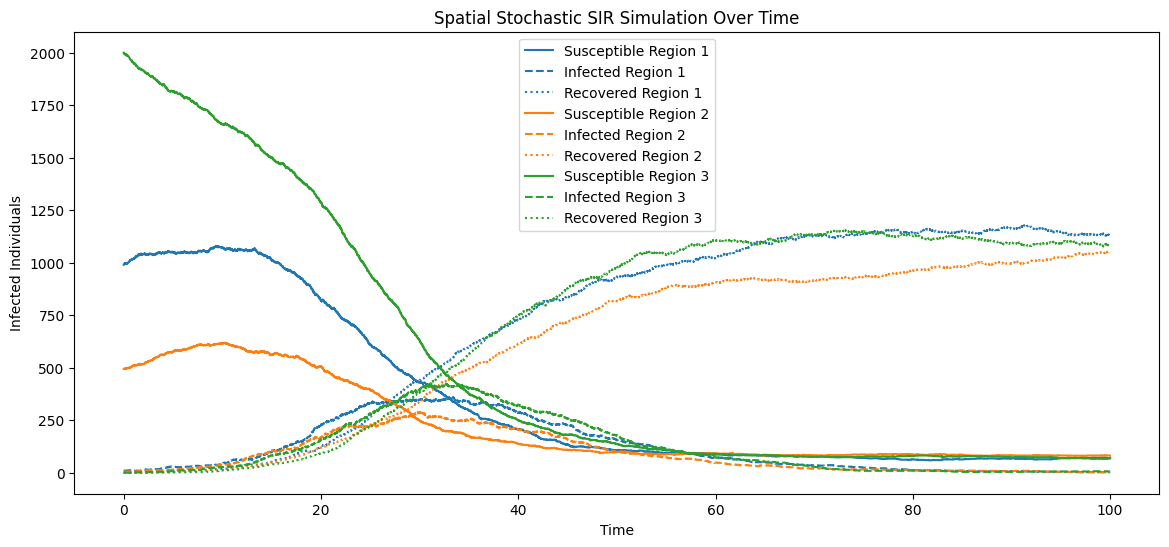

In [13]:
# Define initial states for three locations: (Susceptible, Infected, Recovered)
initial_states = [(990, 10, 0),  # Location 1
                  (495, 5, 0),   # Location 2
                  (2000, 0, 0)]  # Location 3

# Transmission and recovery rates
beta = [0.3, 0.3, 0.3]  # Transmission rate for each location
gamma = [0.1, 0.1, 0.1]  # Recovery rate for each location

# Migration rates between locations
# Rows: from, Columns: to, Values: migration rate
migration_rates = np.array([[0.0, 0.01, 0.02],  # From Location 1 to others
                            [0.01, 0.0, 0.01],  # From Location 2 to others
                            [0.02, 0.01, 0.0]]) # From Location 3 to others

# Run the spatial stochastic SIR simulation
t_max = 100  # Maximum time to simulate
outputs = spatial_stochastic_sir(initial_states, beta, gamma, migration_rates, t_max)

# visualization
colors = plt.cm.tab10.colors 

plt.figure(figsize=(14, 6))
for i, location_data in enumerate(outputs):
    times = [entry[0] for entry in location_data]
    susceptible = [entry[1] for entry in location_data]
    infected = [entry[2] for entry in location_data]
    recovered = [entry[3] for entry in location_data]

    plt.plot(times, susceptible, label=f'Susceptible Region {i+1}', color=colors[i], linestyle='-')
    plt.plot(times, infected, label=f'Infected Region {i+1}', color=colors[i], linestyle='--')
    plt.plot(times, recovered, label=f'Recovered Region {i+1}', color=colors[i], linestyle=':')
    
    # plt.plot(times, infected, label=f'Location {i+1}')

plt.xlabel('Time')
plt.ylabel('Infected Individuals')
plt.legend()
plt.title('Spatial Stochastic SIR Simulation Over Time')
plt.show()
